In [ ]:
# SETUP & DATA LOADING
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import PIL
from scipy.signal import welch
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import pathlib
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [ ]:
# Setting dataset path after mounting
dataset_path = "/content/drive/MyDrive/dataset"
dataset_dir = pathlib.Path(dataset_path)


In [ ]:
print("Contents of the dataset directory:")
for item in os.listdir(dataset_path):
  print(item)

Contents of the dataset directory:
algal leaf 
red leaf spot
healthy
gray light
Anthracnose


In [ ]:
# Obtaining and saving class names
class_names = [x for x in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, x))]
print("Categories:",class_names)

# Setting parameters for feature extraction
train_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
#val_split = 0.1

Categories: ['algal leaf ', 'red leaf spot', 'healthy', 'gray light', 'Anthracnose']


In [ ]:
# Initialize a dictionary to store the count of images for each class
class_image_count = {}

# Iterate through each class directory and count images
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_image_count[class_name] = num_images

# Print the count
for class_name, count in class_image_count.items():
    print(f"Class: {class_name}, Number of Images: {count}")

# Calculate the total number of images in the dataset
total_images = sum(class_image_count.values())
print("Total Number of Images in the Dataset:",total_images)

Class: algal leaf , Number of Images: 113
Class: red leaf spot, Number of Images: 143
Class: healthy, Number of Images: 74
Class: gray light, Number of Images: 100
Class: Anthracnose, Number of Images: 100
Total Number of Images in the Dataset: 530


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
# Load the dataset
all_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    image_size=(img_height, img_width),
    batch_size=train_batch,
    validation_split=0.2,  # 20% of the data will be reserved for validation and testing
    subset="training",
    seed=123,
)

# To get the number of batches in the dataset
num_batches = len(all_ds)

# To calculate the number of batches for each dataset
num_train_batches = round(num_batches * 0.6)
num_val_batches = round(num_batches * 0.2)
num_test_batches = num_batches - num_train_batches - num_val_batches

# To split the dataset into training and remaining sets
train_ds = all_ds.take(num_train_batches)
remaining_ds = all_ds.skip(num_train_batches)

# To further split the remaining data into validation and testing sets
val_ds = remaining_ds.take(num_val_batches)
test_ds = remaining_ds.skip(num_val_batches)

print("\n")
print("Number of batches in training dataset:", num_train_batches)
print("Number of batches in validation dataset:", num_val_batches)
print("Number of batches in testing dataset:", num_test_batches)

Found 530 files belonging to 5 classes.
Using 424 files for training.


Number of batches in training dataset: 2
Number of batches in validation dataset: 1
Number of batches in testing dataset: 1


In [ ]:
# MOBILENETV2 MODEL SETUP
# Setting and saving mobileNetV2 as a model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet')
base_model.trainable = False



# Adding a global average  pooling layer to append to base model above for feature extraction
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
model = tf.keras.Model(inputs, x)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# FEATURE EXTRACTION
# Extracting features for TRAINING data
train_features = []
train_labels = []

for images, labels in train_ds:
    features = model(images)
    train_features.extend(features.numpy())
    train_labels.extend(labels.numpy())

# Extracting features for VALIDATION data
val_features = []
val_labels = []

for images, labels in val_ds:
    features = model(images)
    val_features.extend(features.numpy())
    val_labels.extend(labels.numpy())

# Extracting features for TESTING data
test_features = []
test_labels = []

for images, labels in test_ds:
    features = model(images)
    test_features.extend(features.numpy())
    test_labels.extend(labels.numpy())

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.transform(val_features)
test_features_scaled = scaler.transform(test_features)

# To convert lists to arrays for simpler processing
train_features = np.array(train_features)
train_labels = np.array(train_labels)

val_features = np.array(val_features)
val_labels = np.array(val_labels)

# To convert lists to arrays for testing set
test_features = np.array(test_features)
test_labels = np.array(test_labels)

In [ ]:
# ENSEMBLED MODEL TRAINING & EVALUATION REPORT
# svm and rf classifier setup
svm_classifier = SVC(kernel='linear', random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)#100 Dec-Trees


In [ ]:
# To define both under the name of 'estimators' for stacking
estimators = [
    ('svm', svm_classifier),
    ('rf', rf_classifier)
    ]

In [ ]:
# Initialization of logistic regression as our meta-learner
meta_learner = LogisticRegression()
# Stacking function to ensemble base estimators
stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_learner,
    cv=5  # no. of cross-validation folds
)

In [ ]:
stacking_classifier.fit(train_features, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(cv=5,
                   estimators=[('svm', SVC(kernel='linear', random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42))],
                   final_estimator=LogisticRegression())

In [ ]:
# VALIDATION ACCURACY
# Finding accuracy and classification report for the stacking classifier model
predictions_stacking = stacking_classifier.predict(val_features)
accuracy_stacking_val = accuracy_score(val_labels, predictions_stacking)
print("Stacking Accuracy:", accuracy_stacking_val)
print("Classification Report (Stacking):\n", classification_report(val_labels, predictions_stacking, target_names=class_names))

Stacking Accuracy: 0.9765625
Classification Report (Stacking):
                precision    recall  f1-score   support

  algal leaf        0.95      0.95      0.95        22
red leaf spot       0.97      1.00      0.98        32
      healthy       0.94      0.94      0.94        18
   gray light       1.00      1.00      1.00        19
  Anthracnose       1.00      0.97      0.99        37

     accuracy                           0.98       128
    macro avg       0.97      0.97      0.97       128
 weighted avg       0.98      0.98      0.98       128



In [ ]:
#TESTING ACCUARCY
test_predictions = stacking_classifier.predict(test_features)
# Evaluate on the test set
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Set Accuracy:", test_accuracy)
# Generate classification report for the test set
print("Classification Report (Test Set):\n", classification_report(test_labels, test_predictions, target_names=class_names))



Test Set Accuracy: 0.925
Classification Report (Test Set):
                precision    recall  f1-score   support

  algal leaf        0.78      1.00      0.88         7
red leaf spot       1.00      1.00      1.00        12
      healthy       1.00      0.78      0.88         9
   gray light       0.75      1.00      0.86         3
  Anthracnose       1.00      0.89      0.94         9

     accuracy                           0.93        40
    macro avg       0.91      0.93      0.91        40
 weighted avg       0.94      0.93      0.93        40



In [ ]:
train_predictions = stacking_classifier.predict(train_features)

In [ ]:
#TRAINING ACCUARCY
train_predictions = stacking_classifier.predict(train_features)
# Evaluate on the test set
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Train Set Accuracy:", train_accuracy)
# Generate classification report for the test set
print("Classification Report (Train Set):\n", classification_report(train_labels, train_predictions, target_names=class_names))



Train Set Accuracy: 0.98828125
Classification Report (Train Set):
                precision    recall  f1-score   support

  algal leaf        0.98      0.96      0.97        57
red leaf spot       1.00      1.00      1.00        51
      healthy       0.96      0.98      0.97        47
   gray light       1.00      1.00      1.00        30
  Anthracnose       1.00      1.00      1.00        71

     accuracy                           0.99       256
    macro avg       0.99      0.99      0.99       256
 weighted avg       0.99      0.99      0.99       256



In [ ]:
#ACCURACY OF EVERY CLASS(5)
from sklearn.metrics import accuracy_score

# To calculate the accuracy for each class
class_accuracies = {}
for class_name in class_names:
    class_indices = np.where(val_labels == class_names.index(class_name))[0]
    class_predictions = predictions_stacking[class_indices]
    class_true_labels = val_labels[class_indices]
    class_accuracy = accuracy_score(class_true_labels, class_predictions)
    class_accuracies[class_name] = class_accuracy

# To print the individual accuracies
for class_name, accuracy in class_accuracies.items():
    print(f"Accuracy for class '{class_name}':{accuracy}")

Accuracy for class 'algal leaf ':0.9545454545454546
Accuracy for class 'red leaf spot':1.0
Accuracy for class 'healthy':0.9444444444444444
Accuracy for class 'gray light':1.0
Accuracy for class 'Anthracnose':0.972972972972973


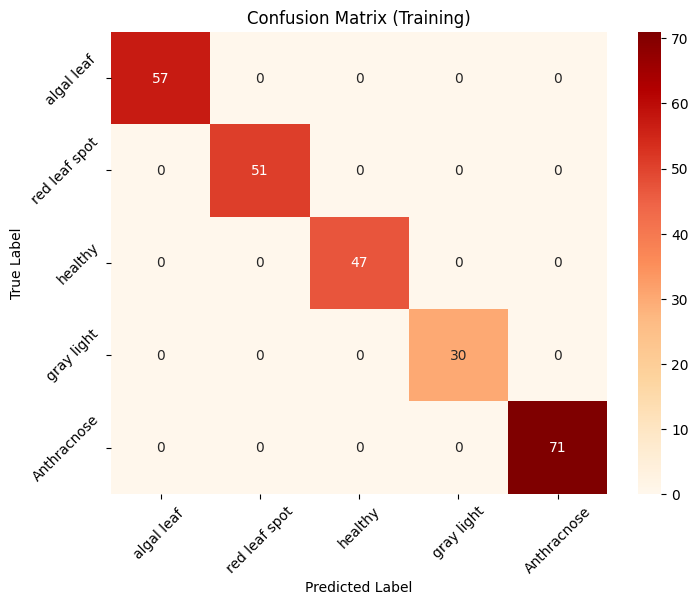

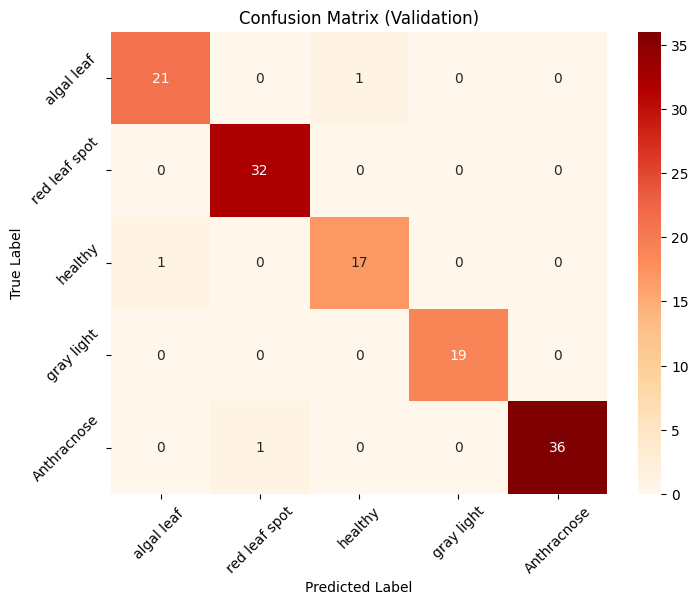

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# To plot the confusion matrices
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.OrRd):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

# To plot the confusion matrice for training data
plot_confusion_matrix(train_labels, train_predictions, class_names, title='Confusion Matrix (Training)')
# To plot the confusion matrice for validation data
plot_confusion_matrix(val_labels, predictions_stacking, class_names, title='Confusion Matrix (Validation)')

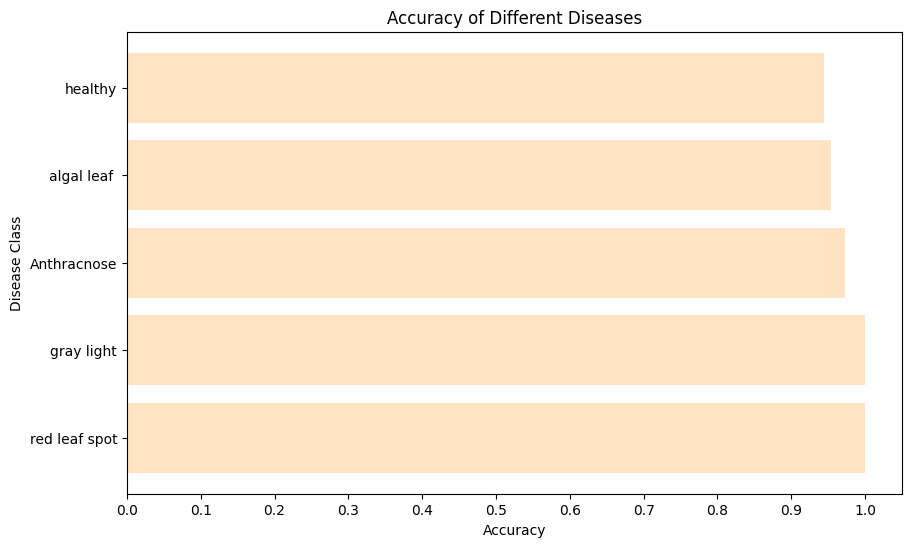

In [ ]:
import matplotlib.pyplot as plt
# To calculate accuracy for each class
class_accuracies = {}
for class_name in class_names:
    class_indices = np.where(val_labels == class_names.index(class_name))[0]
    class_predictions = predictions_stacking[class_indices]
    class_true_labels = val_labels[class_indices]
    class_accuracy = accuracy_score(class_true_labels, class_predictions)
    class_accuracies[class_name] = class_accuracy

# To sort the class accuracies by descending order
sorted_class_accuracies = dict(sorted(class_accuracies.items(), key=lambda item: item[1], reverse=True))

# To plot the accuracies as a horizontal bar graph
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_class_accuracies)), sorted_class_accuracies.values(), color='bisque')
plt.yticks(range(len(sorted_class_accuracies)), sorted_class_accuracies.keys())
plt.xlabel('Accuracy')
plt.ylabel('Disease Class')
plt.title('Accuracy of Different Diseases')
plt.xticks(ticks=np.linspace(0, 1, 11))
plt.show()

In [ ]:
# MODEL SERIALIZATION
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# To save stacking classifier
joblib.dump(stacking_classifier, 'stacking_classifier_model.joblib')
# To load the saved stacking classifier for prediction
loaded_stacking_classifier = joblib.load('stacking_classifier_model.joblib')

In [ ]:
def predict_disease(test_img_path):
    test_image = tf.keras.preprocessing.image.load_img(test_img_path, target_size=(img_height, img_width))
    test_image_array = tf.keras.preprocessing.image.img_to_array(test_image)

    features = model.predict(tf.expand_dims(test_image_array, axis=0)).flatten()
    disease_prediction = stacking_classifier.predict(features.reshape(1, -1))
    class_names = ['Anthracnose', 'algal leaf', 'gray blight', 'healthy', 'red leaf spot']

    predicted_disease = class_names[disease_prediction[0]]
    print("Predicted Disease:", predicted_disease)

    plt.imshow(test_image)
    plt.title("Predicted Disease: " + predicted_disease)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 1s 1s/step
Predicted Disease: healthy


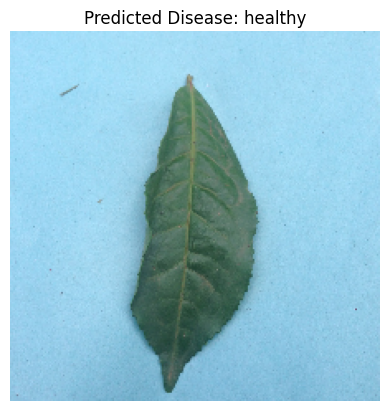

In [ ]:
test_image = '/content/drive/MyDrive/Colab Notebooks/h_d.jpg'
predict_disease(test_image)

1/1 [==============================] - 0s 102ms/step
Predicted Disease: Anthracnose


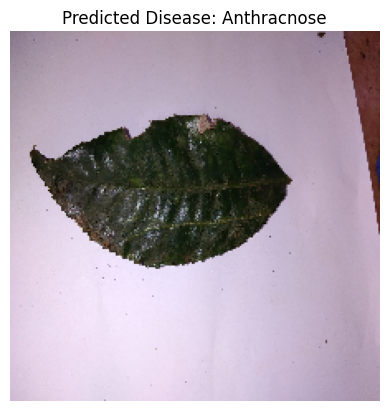

In [ ]:
test_image = '/content/drive/MyDrive/Colab Notebooks/an_d.jpg'
predict_disease(test_image)

1/1 [==============================] - 0s 83ms/step
Predicted Disease: algal leaf


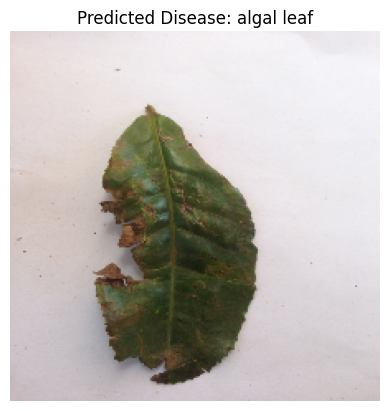

In [ ]:
test_image = '/content/drive/MyDrive/Colab Notebooks/al_d.jpg'
predict_disease(test_image)

1/1 [==============================] - 0s 105ms/step
Predicted Disease: red leaf spot


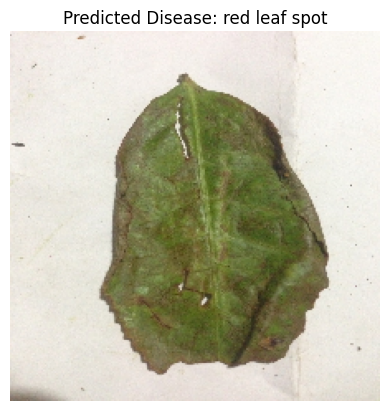

In [ ]:
test_image = '/content/drive/MyDrive/Colab Notebooks/rls_d.jpg'
predict_disease(test_image)

1/1 [==============================] - 0s 57ms/step
Predicted Disease: gray blight


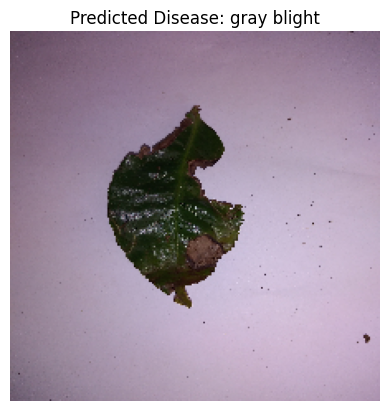

In [ ]:
test_image = '/content/drive/MyDrive/Colab Notebooks/gb_d.jpg'
predict_disease(test_image)

1/1 [==============================] - 0s 71ms/step
Predicted Disease: red leaf spot


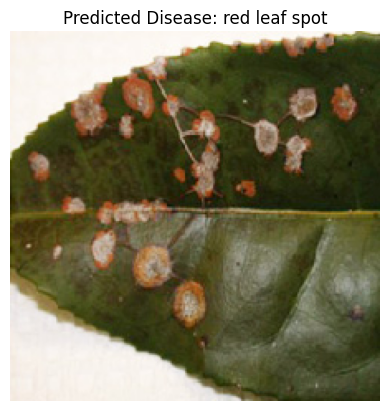

In [ ]:
#TEST IMAGES
test_image = '/content/drive/MyDrive/Colab Notebooks/rls.jpg'
predict_disease(test_image)

1/1 [==============================] - 0s 56ms/step
Predicted Disease: Anthracnose


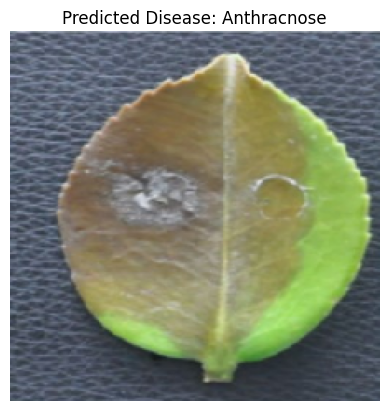

In [ ]:
test_image = '/content/drive/MyDrive/Colab Notebooks/an.jpg'
predict_disease(test_image)

1/1 [==============================] - 0s 55ms/step
Predicted Disease: algal leaf


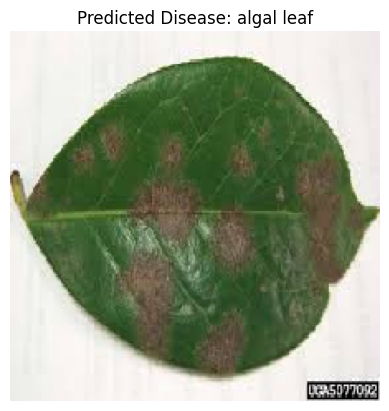

In [ ]:
test_image = '/content/drive/MyDrive/Colab Notebooks/al1.jpg'
predict_disease(test_image)

In [ ]:
#UNIT TEST
import unittest
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

class TestStackingClassifier(unittest.TestCase):
    def tea_sickness_data(self):
        # Sample data setup
        train_features = np.random.rand(100, 100)  # Example train features
        train_labels = np.random.randint(0, 2, size=(100,))  # Example train labels
        val_features = np.random.rand(20, 100)  # Example validation features
        val_labels = np.random.randint(0, 2, size=(20,))  # Example validation labels
        return train_features, train_labels, val_features, val_labels

    def test_stacking_classifier(self):
        train_features, train_labels, val_features, val_labels = self.tea_sickness_data()

        # Stacking classifier setup
        svm_classifier = SVC(kernel='linear', random_state=42)
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        estimators = [('svm', svm_classifier), ('rf', rf_classifier)]
        meta_learner = LogisticRegression()
        stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=meta_learner, cv=5)

        # Training
        stacking_classifier.fit(train_features, train_labels)

        # Predictions
        val_predictions_stacking = stacking_classifier.predict(val_features)

        # Evaluation
        accuracy_stacking = accuracy_score(val_labels, val_predictions_stacking)
        classification_rep_stacking = classification_report(val_labels, val_predictions_stacking)

        # Assertions
        self.assertTrue(accuracy_stacking >= 0.0 and accuracy_stacking <= 1.0)  # Accuracy should be between 0 and 1
        self.assertIsNotNone(classification_rep_stacking)  # Ensure classification report is not None

# Run the tests
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestStackingClassifier))

.
----------------------------------------------------------------------
Ran 1 test in 3.293s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>